<a href="https://colab.research.google.com/github/Ruqyai/Tuwaiq_Academy/blob/main/spark/PySpark_On_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 44.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=71d46fd424a2bea724c2436ac7aadd26977419126d62f546b26d8dfbc76c590e
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark import SparkContext # https://www.tutorialspoint.com/pyspark/pyspark_sparkcontext.htm
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple # https://www.geeksforgeeks.org/namedtuple-in-python/

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

In [3]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [4]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)
socket_stream = ssc.socketTextStream("127.0.0.1", 5553)
lines = socket_stream.window( 20 )

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [5]:
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list # lambda is a function # (lambda arguments : expression)
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) #  Count and remove duplicates. #https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts them in Descending order in a DataFrame.
  .limit(10).registerTempTable("tweets") ) ) #Registers this DataFrame as a temporary table using the given name)

__________
### Before start next ssc.start() you should run TweetListener.py in the terminal
```
python TweetListener.py
```
__________

In [10]:
!wget https://raw.githubusercontent.com/Ruqyai/Tuwaiq_Academy/main/spark/TweetsListener.py

--2022-10-03 14:31:33--  https://raw.githubusercontent.com/Ruqyai/Tuwaiq_Academy/main/spark/TweetsListener.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1706 (1.7K) [text/plain]
Saving to: ‘TweetsListener.py’

TweetsListener.py   100%[===================>]   1.67K  --.-KB/s    in 0s      

2022-10-03 14:31:33 (31.6 MB/s) - ‘TweetsListener.py’ saved [1706/1706]



In [14]:
#run the script/API in the background
import subprocess
subprocess.Popen(["python", "/content/TweetsListener.py"]) 

In [15]:
ssc.start()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0, flags=flags)


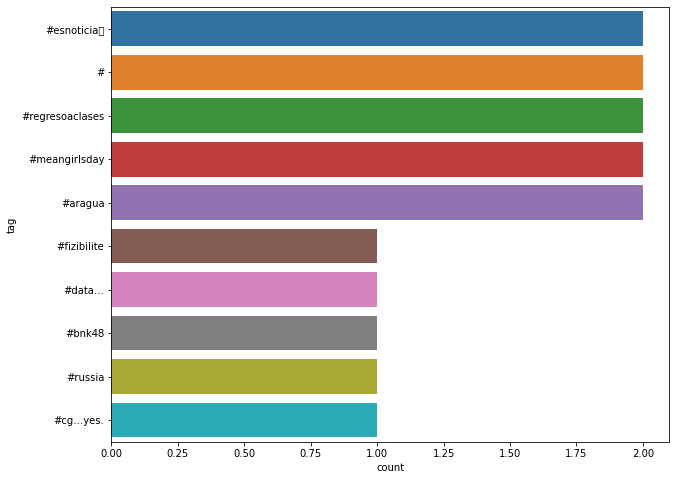

In [17]:
count = 0
while count < 10:
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [18]:
ssc.stop()